In [ ]:
#default_exp graphics

# Graphics

> This module encapsulates the functions used for displaying an optimisation function

In [ ]:
#hide 
#export
from typing import Tuple
from functools import lru_cache

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors

from optimisations.functions import Ifunction

# from tqdm.notebook import tqdm

In [ ]:
#exporti
@lru_cache(maxsize=None)
def contour(function: Ifunction, x_min=-5, x_max=5, y_min=-5, y_max=5, mesh_size=100):
    """
    Returns a (x, y, z) 3D coordinates, where `z = function(x,y)` evaluated on a 
    mesh of size (mesh_size, mesh_size) generated from the linear space defined by 
    the boundaries returned by `function.domain()`.

    This function is usually used for displaying the contour of the diven function.
    """
    xx, yy = np.meshgrid( 
        np.linspace(x_min, x_max, num=mesh_size),
        np.linspace(y_min, y_max, num=mesh_size)
    )
    zz = function(xx, yy)
    return xx, yy, zz

## Zooming

In [ ]:
#export
def zoom(x_domain, y_domain, zoom_factor):
    (x_min, x_max), (y_min, y_max) = x_domain, y_domain

    # zoom
    x_mean = (x_min + x_max) / 2
    y_mean = (y_min + y_max) / 2

    x_min = x_min + (x_mean - x_min) * zoom_factor
    x_max = x_max - (x_max - x_mean) * zoom_factor

    y_min = y_min + (y_mean - y_min) * zoom_factor
    y_max = y_max - (y_max - y_mean) * zoom_factor

    return (x_min, x_max), (y_min, y_max)

The idea of `zooming` is actualy closely related to the `min` and `max` boundaries set on the plots:
* if we reduce the distance between them, we *zoom in*
* if we increase the distance, we *zoom out*

Since *zoom* is usually a proportion of the current view, there's a bit of math to do in order to get the computations correct. 

This section is highly specific and beside the main point but I like to keep it just because it's time spent that I don't want to be lost to history. If you're reading this, you might probbably want to skip it since it isn't clever nor informative..

So the main idea of the zooming that I'm going to implement is described by the image bellow:
* we have some set 'min' and 'max' values
* we have a `mean` (center) between them
* we want to move both `min` and `max` closer to the `mean` by the same amunt (percentage), `f` called a `zooming factor`.

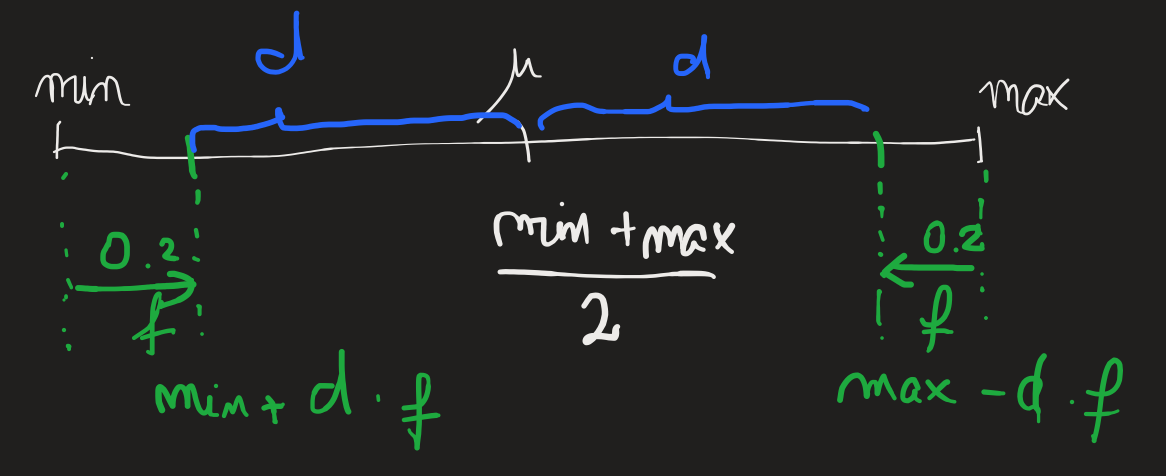

In [ ]:
assert zoom((-5, 5), (-5, 5), 0.1) == ((-4.5, 4.5), (-4.5, 4.5))

Funny enough, these can be vectorized by the numpy transformations bellow

In [ ]:
d = np.array([(-5, 5), (-5, 5)])
zoom_factor = 0.1

means = d.mean(axis=-1)             # computing the means
distances = np.abs(d - means)
change = distances * zoom_factor    # compute the change need 
change_with_direction = change * [1, -1] # add signs for the direction of changes (mins should increase, maxes should decrese in value)
zoomed_d = d + change_with_direction

d + np.abs(d - d.mean(axis=-1)) * [1, -1] * zoom_factor # single line transformation

array([[-4.5,  4.5],
       [-4.5,  4.5]])

Now, we see that the above computation does, an `abs` where we eliminate the sign, and right after that we add it back by multipligin with `[-1, 1]`. If we think in terms of moving from the mean left and right we can simplify the formula a bit, as follows:

In [ ]:
d.mean(axis=-1) - (d.mean(axis=-1) - d) * (1 - zoom_factor)

array([[-4.5,  4.5],
       [-4.5,  4.5]])

If we analitically decompose the `(1 - 0.1)` term and simplify the result, we remain with the bellow formula: 

In [ ]:
d + (d.mean(axis=-1) - d) * zoom_factor

array([[-4.5,  4.5],
       [-4.5,  4.5]])

Which is almost identical with the one we've started from but, as we've observed, does not trim the signs and adds them back.

# 3D Plot

In [ ]:
#exporti
def __log_contour_levels(zz, number_of_contour_lines=35):
    min_function_value = zz.min()   # we use the mesh values because some functions could actually go to -inf, we only need the minimum in the viewable window
    max_function_value = np.percentile(zz, 5) # min(5, zz.max()/2)

    contour_levels = min_function_value + np.logspace(0, max_function_value-min_function_value, number_of_contour_lines)
    return contour_levels

In [ ]:
#export
def plot_function_3d(function: Ifunction, ax=None, azimuth=45, angle=45, zoom_factor=0, show_projections=False, contour_log_scale=True):    
    (x_min, x_max), (y_min, y_max) = zoom(*function.domain(), zoom_factor)

    xx, yy, zz = contour(function, x_min, x_max, y_min, y_max)

    # evaluate once, use in multiple places
    zz_min = zz.min()
    zz_max = zz.max()
    norm = colors.Normalize(vmin=zz_min, vmax=zz_max)

    # put the 2d contour floor, a fit lower than the minimum to look like a reflection
    zz_floor_offset = int((zz_max - zz_min) * 0.065)

    # create 3D axis if not provided
    ax = ax if ax else plt.axes(projection='3d')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(zz.min() - zz_floor_offset, zz.max())

    min_coordinates = function.min()
    ax.scatter3D(min_coordinates[:, 0], min_coordinates[:, 1], min_coordinates[:, 2], marker='.', color='black', s=120, alpha=1, zorder=1)
    

    contour_levels = __log_contour_levels(zz) if contour_log_scale else 200
    contour_color_normalisation = colors.LogNorm(vmin=contour_levels.min(), vmax=contour_levels.max()) if contour_log_scale else colors.Normalize(vmin=zz.min(), vmax=zz.max())

    ax.contourf(xx, yy, zz, zdir='z', levels=contour_levels, offset=zz_min-zz_floor_offset, cmap='Spectral', norm=norm, alpha=0.5, zorder=1)
    if show_projections:
        ax.contourf(xx, yy, zz, zdir='x', levels=300, offset=xx.max()+1, cmap='gray', norm=contour_color_normalisation, alpha=0.05, zorder=1)
        ax.contourf(xx, yy, zz, zdir='y', levels=300, offset=yy.max()+1, cmap='gray', norm=contour_color_normalisation, alpha=0.05, zorder=1)

    ax.plot_surface(xx, yy, zz, cmap='Spectral', rcount=100, ccount=100, norm=norm, shade=False, antialiased=True, alpha=0.6)     
    # ax.plot_wireframe(xx, yy, zz, cmap='Spectral', rcount=100, ccount=100, norm=norm, alpha=0.5)     

    # apply rotation
    ax.view_init(azimuth, angle)

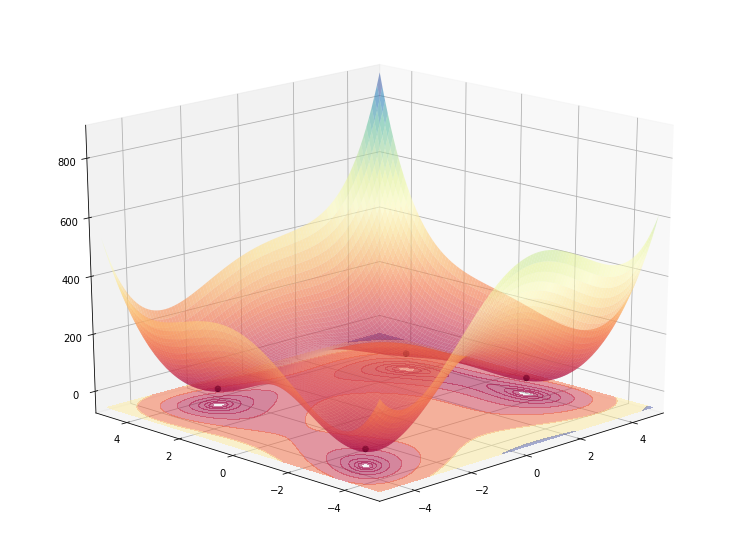

In [ ]:
from optimisations.functions import himmelblau
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection='3d')
plot_function_3d(himmelblau(), ax=ax, azimuth=20, angle=225)

Let's make it interactive so we can play with it a bit. 

*Note: This code will probably not work in the blog post*

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_interactive(azimuth=45, rotation=45, zoom_factor=(-1, 1, 0.1), show_projections={True, False}):
    return plot_function_3d(function=himmelblau(), azimuth=azimuth, angle=rotation, zoom_factor=zoom_factor, show_projections=show_projections)

interactive(children=(IntSlider(value=45, description='azimuth', max=135, min=-45), IntSlider(value=45, descri…

# 2D plot

## Contour with angle rotation options

Note that we have a 3D plot what can handle rotations, we need to allow this capability to the 2D plot as well, since we wish the two charts to move in sync.

What we need to do is use linear algebra and rotate the initial meshgrid of points. We accomplish this by simply multiplying it with a rotation matrix.

Adding rotation to the second plot

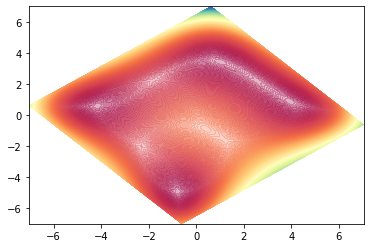

In [ ]:
angle = 40
xx, yy, zz = contour(himmelblau())


radians = angle * np.pi/180

# counter-clockwise rotation matrix
# https://stackoverflow.com/questions/29708840/rotate-meshgrid-with-numpy
rotation_matrix = np.array([
    [np.cos(radians), -np.sin(radians)],
    [np.sin(radians), np.cos(radians)]
])
xx, yy = np.einsum('ji, mni -> jmn', rotation_matrix, np.dstack([xx, yy]))

plt.contourf(xx, yy, zz, levels=1000, cmap='Spectral', norm=colors.Normalize(vmin=zz.min(), vmax=zz.max()), alpha=0.3)

We've successfully rotated the contour, but we see that the axis were left unchanges. So we didn't rotate the plot, but merely it's contents. 

At this point, I guess there are three options:
* use some image processing packages (like `PIL`, `imagemagick`), export the 2D plot as an image, rotate it and then display it
* hide the axes so we don't see that we've actually rotated only the content. 
* use a 3D plot (which can easily suport rotation as we've seen) and set a perpendicular viewing angle (birds-eye view) so the plot looks like a 2D one.

The first option looks like the biggest hack of all since it involves adding at least 2 new dependencies for this sole purpose (plus the additional computation).

The last one is easy to see without further experiments, so we only need to see how option 2 looks like.

Drawing the 2D plot on a 3D Axis and viewed from above. This makes it possible to dispay the rotated axis as well but also makes the plot smaller.

/Users/cristi/Envs/optimisations/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


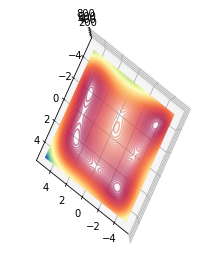

In [ ]:
fig = plt.figure()

ax_ = fig.add_subplot(1, 2, 2, projection='3d')

angle = 125

## plot_function_2d
xx, yy = np.meshgrid( 
    np.linspace(-5, 5, num=100),
    np.linspace(-5, 5, num=100)
)
zz = himmelblau()(xx, yy)

ax_.contour(xx, yy, zz, levels=200, offset=0, cmap='Spectral', norm=colors.Normalize(vmin=zz.min(), vmax=zz.max()), alpha=0.5, zorder=1)
ax_.view_init(90, angle)

plt.tight_layout()

I think I will stick with the 2D approach as the contour is bigger.

## Rotation function



The `rotate` function bellow looks way more complex than we've sketched it out above, and this is because it is now handling two use cases that it needs to disambiguate:
* the case when it receives meshgrids (xx, yy) when called to rotate the contour plots
& the case when it receives points we want to draw on the contour (like the minimum values or the trace of an optimizer) which are not of the same shape as a meshgrid so have a diffrent type of math operation applyed on them (mainly due to vectorisation).

In [ ]:
#export
def rotate(_x: np.ndarray, _y: np.ndarray, angle=45) -> Tuple[np.ndarray, np.ndarray]:
    def __is_mesh(x: np.ndarray) -> bool:
        __is_2d = len(x.shape) == 2
        if __is_2d:
            __is_repeated_on_axis_0 = np.allclose(x.mean(axis=0), x[0, :])
            __is_repeated_on_axis_1 = np.allclose(x.mean(axis=1), x[:, 0])
            __is_repeated_array = __is_repeated_on_axis_0 or __is_repeated_on_axis_1
            return __is_repeated_array
        else:
            return False

    def __is_single_dimension(x: np.ndarray) -> bool:
        # when the function only has one minimum the initial x will have the shape (1,)
        # and doing a np.squeeze before calling this function will result in a x of shape () 
        # when we reach this control point 
        _is_scalar_point = len(x.shape) == 0
        return len(x.shape) == 1 or _is_scalar_point

    def __rotate_mesh(xx: np.ndarray, yy: np.ndarray) -> np.ndarray:
        xx, yy = np.einsum('ij, mnj -> imn', rotation_matrix, np.dstack([xx, yy]))
        return xx, yy

    def __rotate_points(x: np.ndarray, y: np.ndarray) -> np.ndarray:
        points = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))
        # anti-clockwise rotation matrix
        x, y = np.einsum('mi, ij -> jm',  points, np.array([
            [np.cos(radians), -np.sin(radians)],
            [np.sin(radians), np.cos(radians)]
        ]))
        return x, y

    # apply rotation
    angle = (angle + 90) % 360
    radians = angle * np.pi/180

    # clockwise rotation matrix
    rotation_matrix = np.array([
        [np.cos(radians), np.sin(radians)],
        [-np.sin(radians), np.cos(radians)]
    ])

    if __is_mesh(_x) and __is_mesh(_y):
        _x, _y = __rotate_mesh(_x, _y)
    elif __is_single_dimension(np.squeeze(_x)) and __is_single_dimension(np.squeeze(_y)):
        def __squeeze(_x):
            """
            We need to reduce the redundant 1 domensions from shapes like (3, 1, 2) to (3, 2), 
            but at the same time, making sure we don't end up with scalar values (going from (1, 1) to a shape ())

            We need at least a shape of (1,)
            """
            if len(np.squeeze(_x).shape) == 0:
                return np.array([np.squeeze(_x)])
            else:
                return np.squeeze(_x)

        _x, _y = __squeeze(_x), __squeeze(_y) 
        _x, _y = __rotate_points(_x, _y)
    else:
        raise AssertionError(f"Unknown rotation types for shapes {_x.shape} and {_y.shape}")
    return _x, _y

The `np.einsum` part is the core of the function, and it's operation is more complex, leaving its explanation for a future post. 


Another interesting bit of it is the way the code bellow works, namely how the parameters are returned. 

```python
xx, yy = np.einsum('ij, mnj -> imn', rotation_matrix, np.dstack([xx, yy]))
```


Normally, any `np.` prefixed operation returns a `np.ndarray` but in this case we see that the `enisum` function is able to destructure the return into two separate parameters `xx` and `yy`. This happens with the help of the `np.dstack` function.

Let's see what it does, bellow:

In [ ]:
print(np.dstack([xx, yy]).shape)
np.dstack([xx, yy])[:3, :3, :]

(100, 100, 2)


array([[[-5.       , -5.       ],
        [-4.8989899, -5.       ],
        [-4.7979798, -5.       ]],

       [[-5.       , -4.8989899],
        [-4.8989899, -4.8989899],
        [-4.7979798, -4.8989899]],

       [[-5.       , -4.7979798],
        [-4.8989899, -4.7979798],
        [-4.7979798, -4.7979798]]])

So `dstack` just made a stack of it's arguments, on a new, rightmost axis (the last `2` value from the shape). This shape, coupled with the specified `einsum` operation, where both `i` and `j` are equal to `2` gives a result with the shape of (2, 100, 100) semantically similar to a tuple `(xx.shape(100, 100), yy.shape(100, 100))`. This shape enables the python language to destructure this return into `2` independent values, the ones we actually wanted. 

#### Single points rotation

The gist of single points rotation is a matrix multiplication but since the meshgrid is implemented in `einsum` notation as is rather elegant, at least because of the arguments decomposition trick, I'll try experimenting a bit to replicate the matrix multiplication it with `einsum` as well.

In [ ]:
angle = 225

# apply rotation
angle = (angle) % 360
radians = angle * np.pi/180


# clockwise rotation matrix
rotation_matrix = np.array([
    [np.cos(radians), -np.sin(radians)],
    [np.sin(radians), np.cos(radians)]
])


points = np.array([
    [1, 1],
    [-2, 2],
    [3, -3],
    [4, 4]
])

function = himmelblau()
coords = function.coord(points)
coords[:, [0, 1]] @ rotation_matrix

array([[-1.41421356e+00, -2.22044605e-16],
       [ 4.44089210e-16, -2.82842712e+00],
       [-4.44089210e-16,  4.24264069e+00],
       [-5.65685425e+00, -8.88178420e-16]])

Ok, this is the (correct) result we're getting using the plain matrix multiplication. Our goal is the `einsum` operation that computes these, but reshapes them as well in `(2, 4)` so we can later on decompose them as `(4,)` and `(4,)` into `x` and `y` coordinates. 

We start of with 4 points, where we also have the `z` value (the function evaluation on the first two coordinates), so a shape of `(4, 2+1)`

In [ ]:
coords.shape

(4, 3)

We'll be receiving `x` and `y` values in the following shape, so this is what we have to work with:

In [ ]:
_x = coords[:, [0]]
_y = coords[:, [1]]
_x.shape, _y.shape

((4, 1), (4, 1))

Since the `rotation_matrix` is of shape `(2,2)`, the final `einsum` operation is:

```
mi, ij -> jm

or 
(nr_points, 2), (2, 2) -> (2, nr_points)
```

In [ ]:
__x, __y = np.einsum('mi, ij -> jm',  np.hstack((coords[:, [0]], coords[:, [1]])), rotation_matrix)
__x, __y

(array([-1.41421356e+00,  4.44089210e-16, -4.44089210e-16, -5.65685425e+00]),
 array([-2.22044605e-16, -2.82842712e+00,  4.24264069e+00, -8.88178420e-16]))

## Actual function

Again, let's wrap everything up in a single function to see where we are up until now. 

In [ ]:
#export
def plot_function_2d(function: Ifunction, ax=None, angle=45, zoom_factor=0, contour_log_scale=True):
    (x_min, x_max), (y_min, y_max) = zoom(*function.domain(), zoom_factor)

    xx, yy, zz = contour(function, x_min, x_max, y_min, y_max)
        
    ax = ax if ax else plt.gca()
    
    xx, yy = rotate(xx, yy, angle=angle)    # I wonder why I shoudn't also rotate zz?!
    
    contour_levels = __log_contour_levels(zz) if contour_log_scale else 200
    contour_color_normalisation = colors.LogNorm(vmin=contour_levels.min(), vmax=contour_levels.max()) if contour_log_scale else colors.Normalize(vmin=zz.min(), vmax=zz.max())
    ax.contour(xx, yy, zz, levels=contour_levels, cmap='Spectral', norm=contour_color_normalisation, alpha=0.5)
    
    min_coords = function.min()
    
    _x, _y = rotate(min_coords[:, 0], min_coords[:, 1], angle=angle)
    
    ax.scatter(_x, _y)
    ax.axis("off")

    # We need to use the min and max values for the ration result, not from the initial min, max values of the function area
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

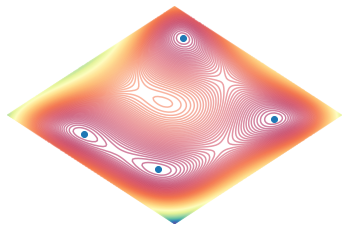

In [ ]:
plot_function_2d(himmelblau(), contour_log_scale=False)

# Joint plot

Using both 2D and 3D plotting function we can combine them to be shown on the same figure, and using the same rotation.

As allways, we will first sketch the code in bulk then tie it up in a single function.

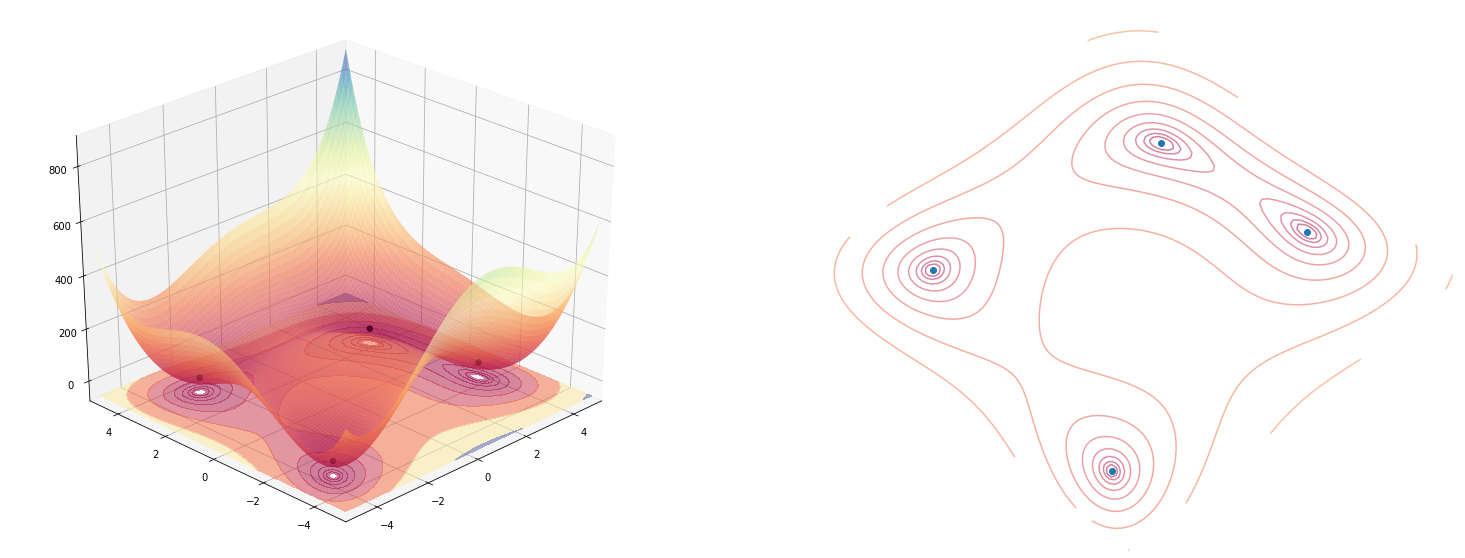

In [ ]:
fig = plt.figure(figsize=(26, 10))

ax_3d = fig.add_subplot(1, 2, 1, projection='3d')
ax_2d = fig.add_subplot(1, 2, 2)

angle = 225

function = himmelblau()

plot_function_3d(function, ax=ax_3d, azimuth=30, angle=angle)
plot_function_2d(function, ax=ax_2d, angle=angle)

The 2D and 3D plots can now be combined in a unified function that you can see bellow:

In [ ]:
#export
def plot_function(function: Ifunction, angle=45, zoom_factor=0, azimuth_3d=30, fig=None, ax_2d=None, ax_3d=None, contour_log_scale=True):
    fig = plt.figure(figsize=(26, 10)) if fig is None else fig
    ax_3d = fig.add_subplot(1, 2, 1, projection='3d') if ax_3d is None else ax_3d
    ax_2d = fig.add_subplot(1, 2, 2) if ax_2d is None else ax_2d

    plot_function_3d(function=function, ax=ax_3d, azimuth=azimuth_3d, angle=angle, zoom_factor=zoom_factor, contour_log_scale=contour_log_scale)
    plot_function_2d(function=function, ax=ax_2d, angle=angle, zoom_factor=zoom_factor, contour_log_scale=contour_log_scale)

    return fig, ax_3d, ax_2d

# Usage examples

(<Figure size 1872x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x138068470>)

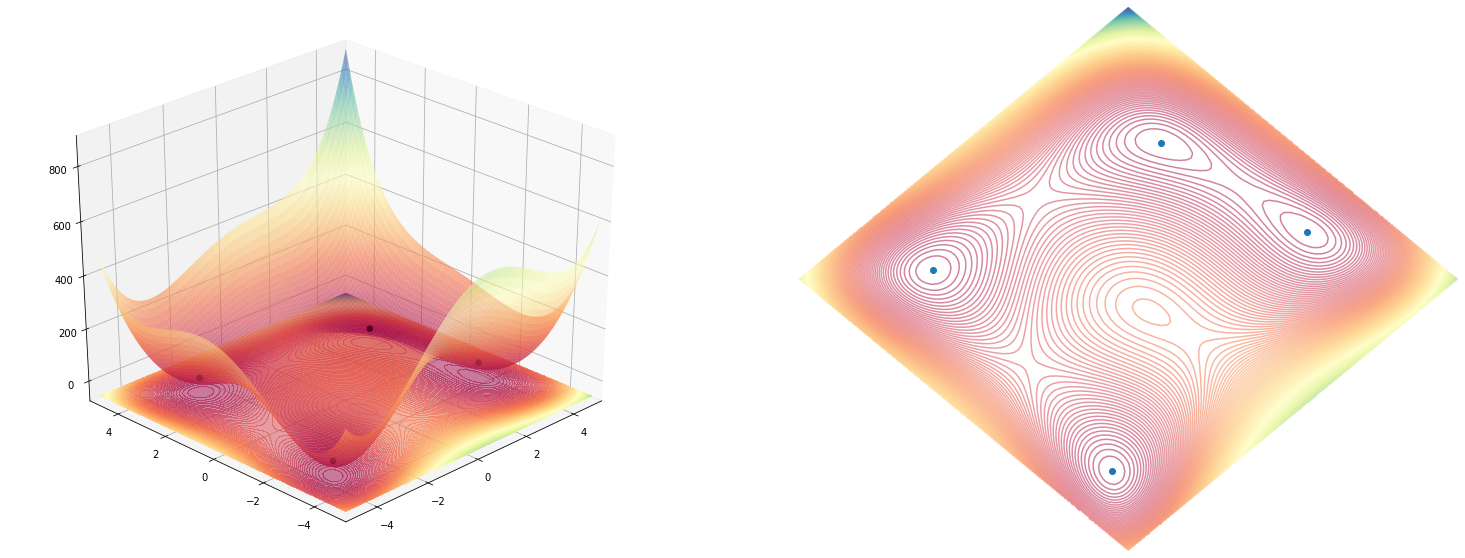

In [ ]:
from optimisations.functions import *
plot_function(himmelblau(), angle=225, contour_log_scale=False)

(<Figure size 1872x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137579c18>)

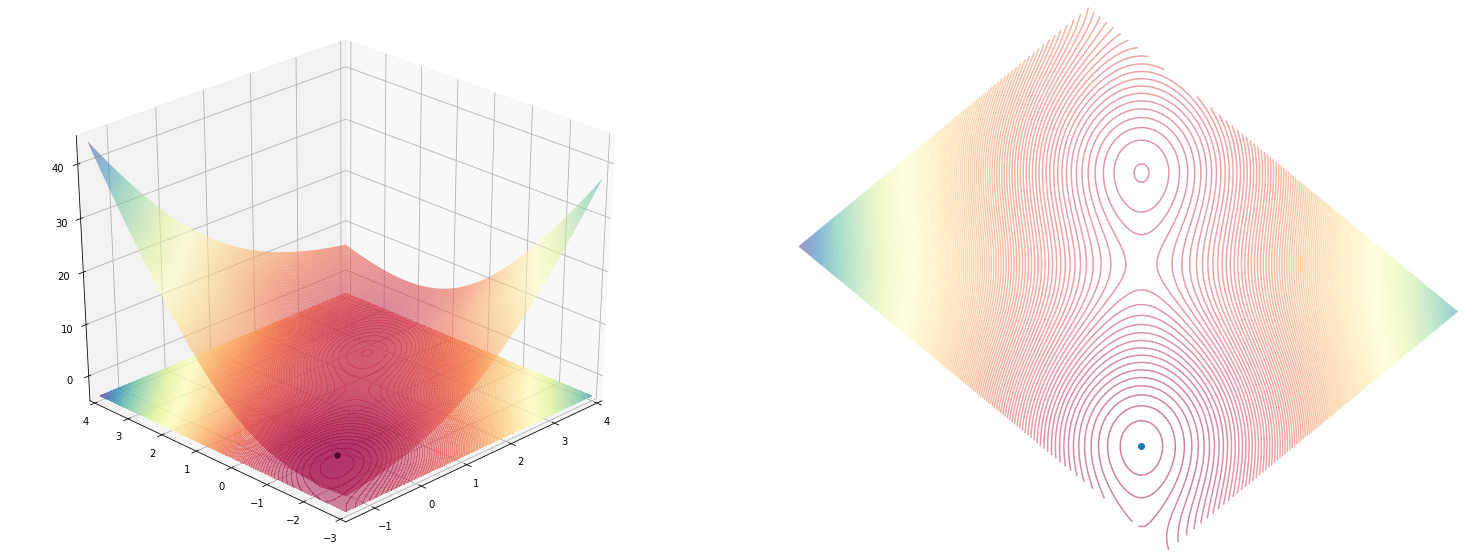

In [ ]:
plot_function(mc_cormick(), angle=225, contour_log_scale=False)

(<Figure size 1872x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13a6f6f60>)

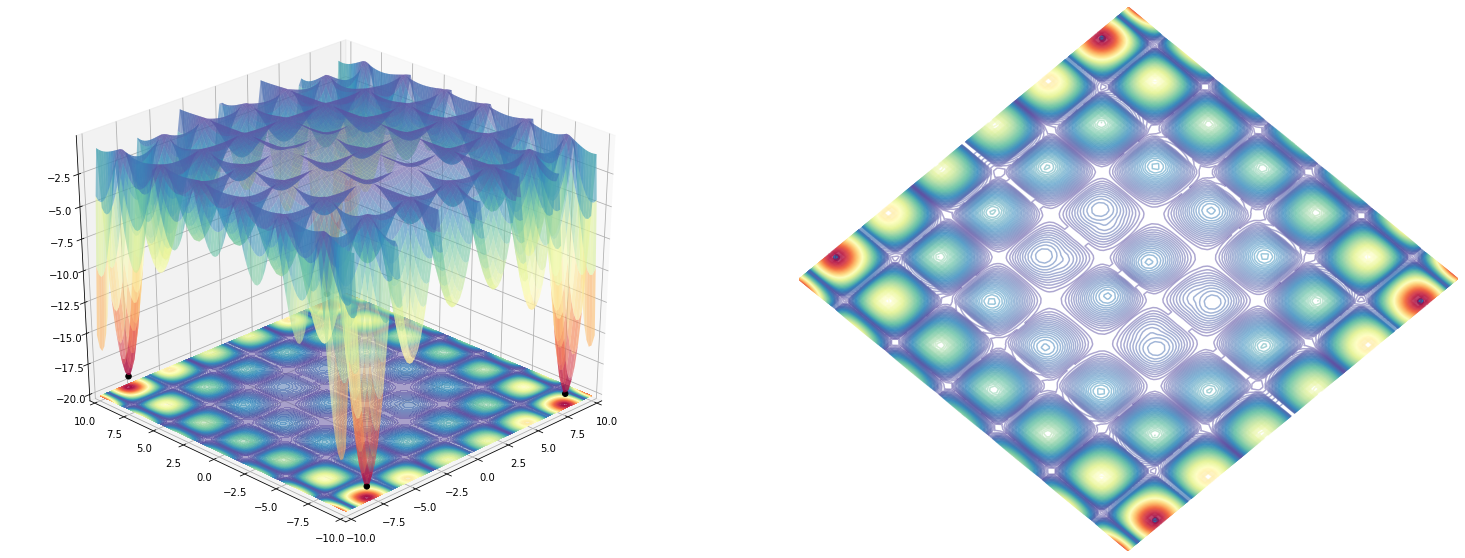

In [ ]:
plot_function(holder_table(), angle=225, contour_log_scale=False)

Let's see all of our functions defined

In [ ]:
#export
def plot_all_functions(functions: dict):
    nr_functions = len(functions)

    fig = plt.figure(figsize=(13, 5*nr_functions))
    for i, (name, function) in enumerate(functions.items(), start=1):
        ax_3d = fig.add_subplot(nr_functions, 2, i*2-1, projection='3d')
        ax_2d = fig.add_subplot(nr_functions, 2, i*2)
        ax_3d.title.set_text(f"{name}")
        try:
            plot_function(function, fig=fig, ax_2d=ax_2d, ax_3d=ax_3d, angle=225)
        except:
            plot_function(function, fig=fig, ax_2d=ax_2d, ax_3d=ax_3d, angle=225, contour_log_scale=False)

    ax_2d.text(1, 0, 'www.clungu.com', transform=ax_2d.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

/Users/cristi/Envs/optimisations/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  del sys.path[0]
/Users/cristi/Envs/optimisations/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]


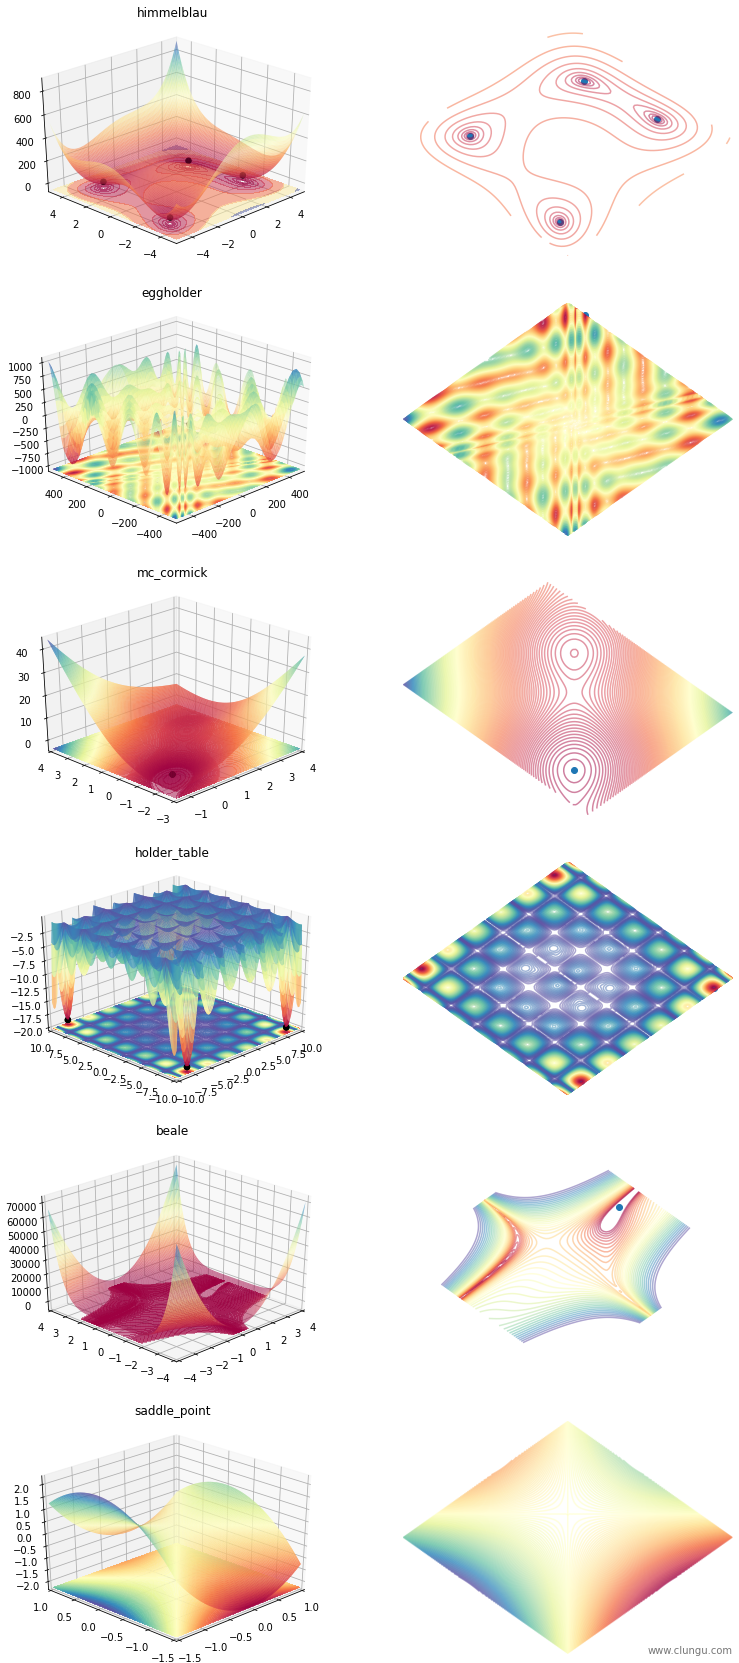

In [ ]:
from optimisations.functions import Function
plot_all_functions(Function)